In [1]:
import numpy as np
from math import pi
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
import zfit

#from utils.kin_utils_2 import *
from utils.BtoKll_utils import *

ztf = zfit.ztf
ztyping = zfit.util.ztyping
ztypes = zfit.settings.ztypes

/Users/davide/miniconda3/envs/zfit_env/lib/python3.6/site-packages/zfit/util/execution.py:57: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
zfit.run.check_numerics = False
zfit.settings.set_verbosity(10)

In [3]:
mmu_mass = 0.5
mB_mass=5280
mKst_mass=892

lower_q2= 4*mmu_mass*mmu_mass
upper_q2=(mB_mass-mKst_mass)*(mB_mass-mKst_mass)

#lower_q= 2*mmu_mass
#upper_q=(mB_mass-mKst_mass)



In [32]:
class dGamma(zfit.pdf.ZPDF):
    
    _PARAMS = ['mB','mKst','ml']
    _N_OBS = 2
    VALID_LIMITS={
                  'cos_theta_l':(-1.,1.),
                  'q2': (lower_q2, upper_q2),
                  #'Eg': (cutoff, 10)
                 }
    
    def _unnormalized_pdf(self, x):
        
        ml = self.params['ml']
        mB = self.params['mB']
        mKst = self.params['mKst']
        
        q2, cos_theta_l = x.unstack_x()
        #pdf = matrix_elt(q2, ml, mB, mKst, cos_theta_l)*dphi2(mB,mKst,ztf.sqrt(q2))*dphi2(ztf.sqrt(q2),ml,ml)
        pdf = dphi2(mB,mKst,ztf.sqrt(q2))*dphi2(ztf.sqrt(q2),ml,ml)
        #pdf= phase_space(q2, ml, mB, mKst)
        #pdf = beta_l(q2, ml)
        
        return pdf


In [33]:
mlepton_par = zfit.Parameter('ml', mmu_mass)
mB_par = zfit.Parameter('mB', mB_mass)
mKst_par = zfit.Parameter('mKst', mKst_mass)

NameAlreadyTakenError: Another parameter is already named ml. Use a different, unique one.

In [34]:
lower = ((lower_q2,  -1.),)
upper = ((upper_q2,   1.),)

obs = zfit.Space(["q2","cos_theta_l"], limits=(lower,upper))


In [35]:
pdf = dGamma(obs=obs, ml = mlepton_par, mB = mB_par, mKst = mKst_par)

In [36]:
n_events=1000000

In [37]:
sampler = pdf.create_sampler(n=n_events)

In [38]:
for i in range(1):
    sampler.resample()


In [39]:
sample=sampler.to_pandas()

In [40]:
q2vals_MC = np.array([sample['q2'][i] for i in range(n_events)])
q2vals2 = q2vals_MC.reshape(n_events,1)

cos_theta_vals_MC = np.array([sample['cos_theta_l'][i] for i in range(n_events)])
cos_theta_vals = cos_theta_vals_MC.reshape(n_events,1)

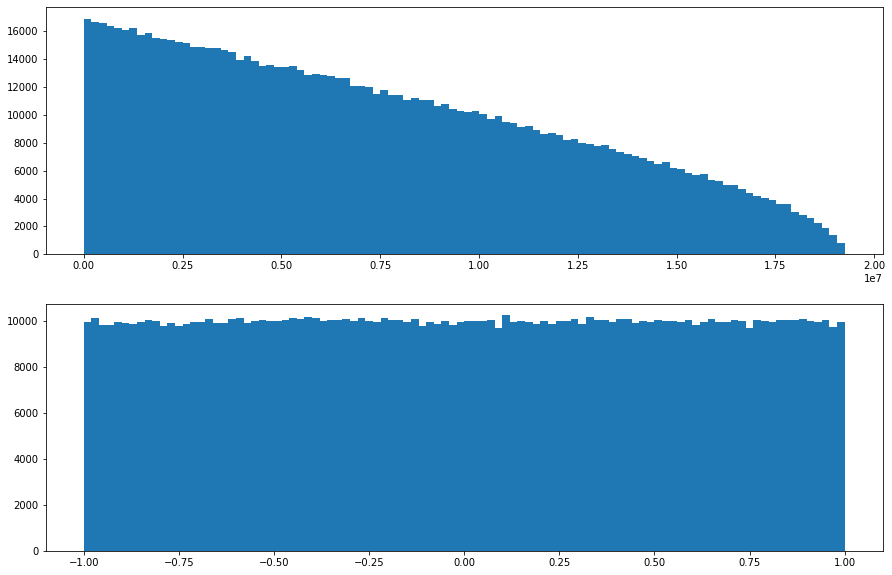

In [41]:

plt.subplot(2,1,1)
a=plt.hist(q2vals2,bins=100);
plt.subplot(2,1,2)
b=plt.hist(cos_theta_vals,bins=100);
fig = plt.gcf()
fig.set_size_inches(15,10)

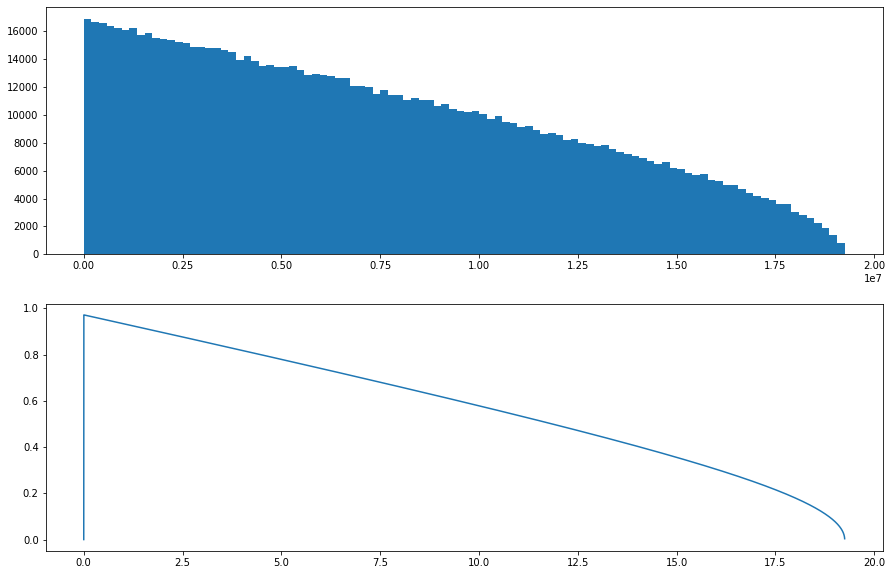

In [42]:
vals=np.arange(lower_q2,upper_q2,1000)
f=dphi2_np(np.sqrt(vals),mmu_mass,mmu_mass)*dphi2_np(mB_mass,mKst_mass,np.sqrt(vals))
plt.subplot(2,1,1)
a=plt.hist(q2vals2,bins=100);

plt.subplot(2,1,2)
plt.plot(vals/1e6,f) 
fig = plt.gcf()
fig.set_size_inches(15,10)

In [43]:
def momenta_map(q2, cos_theta_l, m_l):
    
    n_events = q2.shape[0]
    
    sin_theta_l = np.sqrt(1-np.square(cos_theta_l))

    beta = dphi2_np(np.sqrt(q2), mmu_mass, mmu_mass)
    lambd = lambda_function_np(mB_mass,mKst_mass,np.sqrt(q2))
    
    phi_l = np.random.uniform(low=-pi,high=pi, size=(n_events,1))
    cos_phi_l = np.cos(phi_l)
    sin_phi_l = np.sin(phi_l)

    p1_1 = 0.5*np.sqrt(q2)*beta*sin_theta_l*cos_phi_l
    p1_2 = 0.5*np.sqrt(q2)*beta*sin_theta_l*sin_phi_l
    p1_3 = 0.5*np.sqrt(q2)*beta*cos_theta_l
    p1_0 = 0.5*np.sqrt(q2)
    
    p1 = np.concatenate([      p1_1,
                               p1_2,
                               p1_3,
                               p1_0], axis =1)
    
    p2 = np.concatenate([      -p1_1,
                               -p1_2,
                               -p1_3,
                                p1_0], axis =1)
    

    
    EKst_B = (np.square(mB_mass)+np.square(mKst_mass)-q2)/(2*mB_mass)
    modKst_B = np.sqrt(lambd)/(2*mB_mass)
    
    phi_Kst = np.random.uniform(low=-pi,high=pi, size=(n_events,1))
    theta_Kst = np.random.uniform(low=0,high=pi, size=(n_events,1))
    
    cos_phi_Kst = np.cos(phi_Kst)
    sin_phi_Kst = np.sin(phi_Kst)
        
    cos_theta_Kst = np.cos(theta_Kst)
    sin_theta_Kst = np.sin(theta_Kst)
        
    pKst_B_0 = EKst_B
    pKst_B_1 = modKst_B*sin_theta_Kst*cos_phi_Kst
    pKst_B_2 = modKst_B*sin_theta_Kst*sin_phi_Kst
    pKst_B_3 = modKst_B*cos_theta_Kst
    
    q_B_0 =  mB_mass - EKst_B
    q_B_1 = - pKst_B_1
    q_B_2 = - pKst_B_2
    q_B_3 = - pKst_B_3
    
    pKst_B = np.concatenate([    pKst_B_1,
                                 pKst_B_2,
                                 pKst_B_3,
                                 pKst_B_0], axis =1)
    
    q_B = np.concatenate([       q_B_1,
                                 q_B_2,
                                 q_B_3,
                                 q_B_0,], axis =1)
    q_B_vec = np.concatenate([
                            q_B_1,
                            q_B_2,
                            q_B_3,
                            ], axis=1)
    
    beta_B = q_B_vec/q_B_0
    
    p1_B = lorentz_boost_np(p1, beta_B)
    p2_B = lorentz_boost_np(p2, beta_B)
    
    
    return  pKst_B, q_B, p1_B, p2_B, p1, p2

In [44]:
pKst_B, q_B, p1_B, p2_B, p1, p2 = momenta_map(q2vals2, cos_theta_vals, mmu_mass)

In [45]:
np.sqrt(scalar_product_4_np(p2_B,p2_B)).mean()

0.5000000000058044

In [46]:
np.sqrt(scalar_product_4_np(pKst_B,pKst_B)).mean()

892.0

In [47]:
(pKst_B+p1_B+p2_B)[:,3].mean()

5280.0

In [48]:
(pKst_B+p1_B+p2_B)[:,0].mean()

8.941619977775872e-14

In [49]:
(pKst_B+p1_B+p2_B)[:,1].mean()

-2.012661423633766e-14

In [50]:
(pKst_B+p1_B+p2_B)[:,2].mean()

-2.0537912082119192e-13

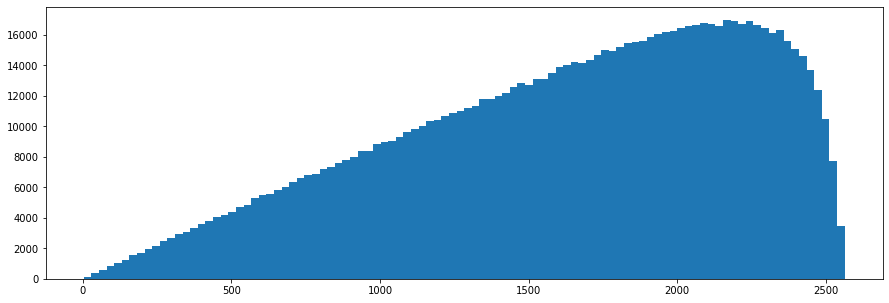

In [51]:
plt.hist(p1_B[:,3],bins=100);
fig = plt.gcf()
fig.set_size_inches(15,5)

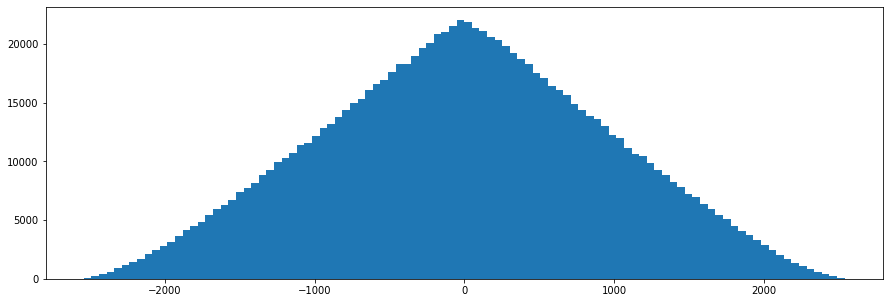

In [52]:
plt.hist(p1_B[:,0],bins=100);
fig = plt.gcf()
fig.set_size_inches(15,5)

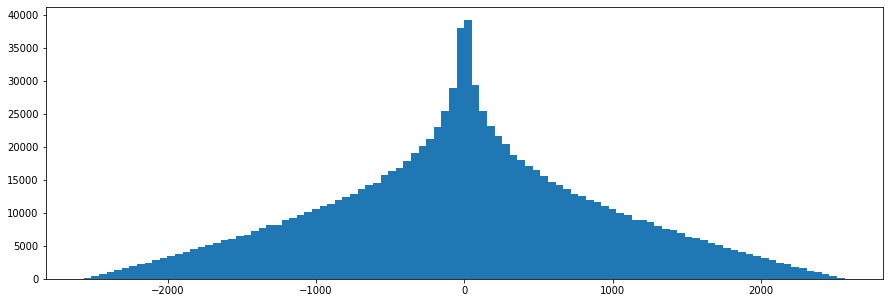

In [53]:
plt.hist(pKst_B[:,0],bins=100);
fig = plt.gcf()
fig.set_size_inches(15,5)

In [54]:
p1_B_to_boost=p1_B
p2_B_to_boost=p2_B

In [55]:
p1_q = lorentz_boost_np(p1_B_to_boost, -q_B[:,0:3]/q_B[:,3:4])
p2_q = lorentz_boost_np(p2_B_to_boost, -q_B[:,0:3]/q_B[:,3:4])

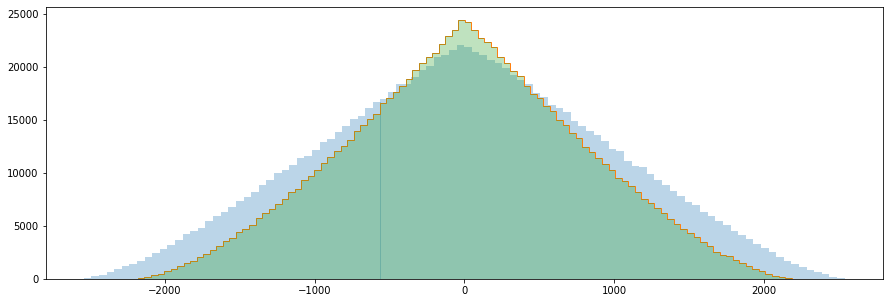

In [56]:
plt.hist(p1_B[:,0],alpha=0.3,bins=100);
plt.hist(p1[:,0],histtype="step",bins=100);
plt.hist(p1_q[:,0],alpha=0.3,bins=100);
fig = plt.gcf()
fig.set_size_inches(15,5)

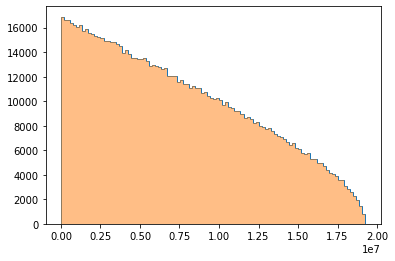

In [57]:
plt.hist(scalar_product_4_np((p1_B+p2_B),(p1_B+p2_B)),histtype="step",bins=100);
plt.hist(scalar_product_4_np((p1_q+p2_q),(p1_q+p2_q)),alpha=0.5,bins=100);


In [58]:
z=np.array([[0.,0.,1.,0] for i in range(n_events)])

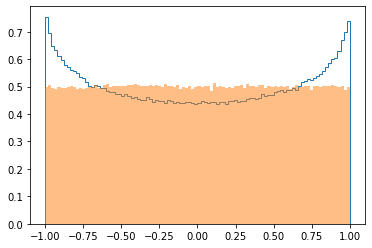

In [59]:
cos_theta_l_np=get_costheta_l_np(p1_B,z)
cos_theta_l_np_2=get_costheta_l_np(p1_q,z)
plt.hist(cos_theta_l_np,bins=100, histtype="step", density=True);
plt.hist(cos_theta_l_np_2,bins=100, alpha=0.5,density=True);